# Part 3 - RNN Feature Engineering

The first thing we can do is pin our GPU-based computations to a specific GPU. The `GPU_id` can be changed in order to use a different GPU. The instance in this tutorial uses 2x P40 GPUs, so you should be able to set `GPU_id` to `0` or `1`

In [1]:
import os
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import warnings
warnings.filterwarnings("ignore")
import math
import cudf as gd
import pandas as pd
import numpy as np
from numba import cuda
import time
import matplotlib.pyplot as plt
%matplotlib inline

print(gd.__version__)

0.9.0a+1077.g7ecea1c.dirty


In [3]:
PATH = '/home/cjnolet/workspace/notebooks-extended/competition_notebooks/kaggle/plasticc/data'

### Read data

The first thing we do for our feature engineering is load our training set CSV in to a Dataframe

In [4]:
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

train_gd = gd.read_csv('%s/training_set.csv'%PATH, names=ts_cols,dtype=ts_dtypes,skiprows=1)

In [5]:
train_gd.head().to_pandas()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.421875,2,-544.810303,3.622952,1
1,615,59750.429688,1,-816.434387,5.553370,1
2,615,59750.437500,3,-471.385498,3.801213,1
3,615,59750.441406,4,-388.984955,11.395031,1
4,615,59752.406250,2,-681.858826,4.041203,1


### Normalization

Let's histogram the `flux` and `flux_err` values to get a feel for their distributions.

Text(0.5, 1.0, 'Original data')

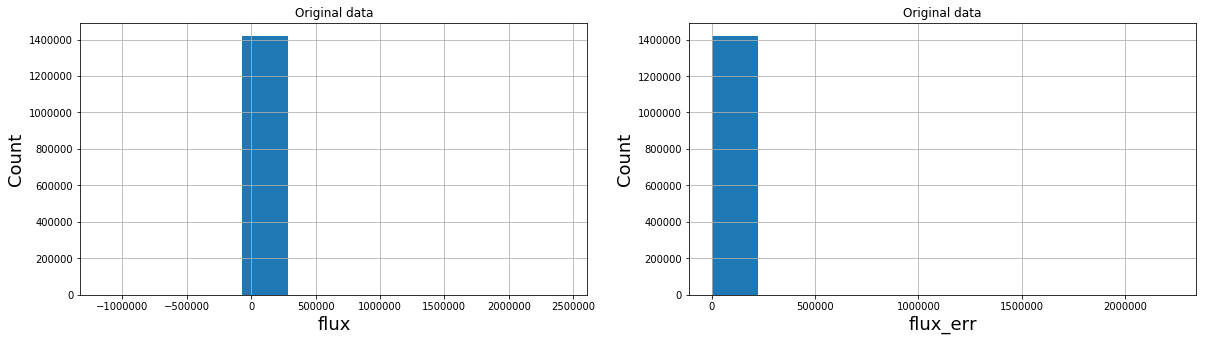

In [6]:
fig, axs = plt.subplots(1,2, figsize=(20, 5))
ax = train_gd.flux.to_pandas().hist(ax=axs[0])

ax.set_xlabel('flux', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('Original data')

ax = train_gd.flux_err.to_pandas().hist(ax=axs[1])

ax.set_xlabel('flux_err', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('Original data')

As can be seen from the charts above, most of the values occur in the bin closest to zero. This bin also eclipses the bins with smaller numbers of values. A log transform should help us normalize the values so we can better analyze the distribution.

A couple more details worth noting here:
- There are extreme negative values in `flux`, which cannot be log-transformed. These will need to be clipped
- The `flux_err` is all non-negative so we can apply log-transform directly

In [7]:
train_gd['flux'] = train_gd['flux'].applymap(lambda x: math.log1p(x+10) if x>-10 else 0)
train_gd['flux_err'] = train_gd['flux_err'].applymap(lambda x: math.log1p(x))

Text(0.5, 1.0, 'After log transformation')

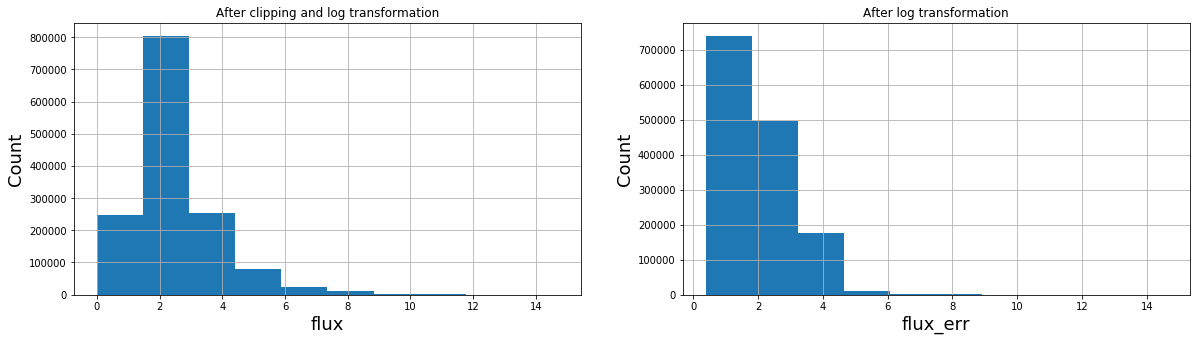

In [8]:
fig, axs = plt.subplots(1,2, figsize=(20, 5))
ax = train_gd.flux.to_pandas().hist(ax=axs[0])
ax.set_xlabel('flux', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('After clipping and log transformation')

ax = train_gd.flux_err.to_pandas().hist(ax=axs[1])
ax.set_xlabel('flux_err', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('After log transformation')

### Differentiation and Segmentation

First let's look at one light curve.

In [9]:
def scatter(x,y,values,xlabel='x',ylabel='y',title=None,xlim=None):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    colors = np.array([colors[i] for i in values])
    ps = []
    bs = []
    bands = ['passband_%s'%i for i in ['u', 'g', 'r', 'i', 'z','y']]
    for i in sorted(np.unique(values)):
        mask = values==i
        if len(x[mask]):
            p = plt.scatter(x[mask],y[mask],c=colors[mask])
            ps.append(p)
            bs.append(bands[i])
    plt.legend(ps,bs,scatterpoints=1)
    if title is not None:
        plt.title(title)
    plt.grid()
    if xlim is None:
        plt.xlim([np.min(x)-10,np.min(x)+1500])
    else:
        plt.xlim(xlim)
    plt.ylabel('y: %s'%ylabel)
    plt.xlabel('x: %s'%xlabel)

<a id="lightcurve"></a>
Original light curve.

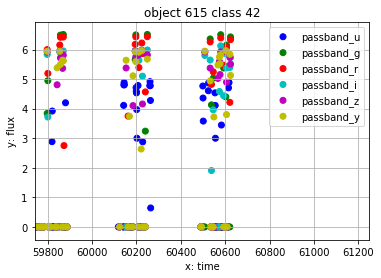

In [10]:
oid = 615
sample = train_gd[train_gd['object_id']==oid].to_pandas()
scatter(sample['mjd'].values,
        sample['flux'].values,
        values=sample['passband'].values,
        xlabel='time',ylabel='flux',title='object %d class 42'%oid)

We make the following observations:
- There are gaps in the curve along the time axis. This light curve can be spit to three separate sequences.
- The absolute value of timestamp `mjd` is not useful. 

Instead, we want to learn how `flux` varies over timestamp `mjd`, namely $\frac{\nabla flux}{\nabla mjd}$

In [11]:
def delta_in_group(val,val_delta):
    """
    Difference the values in a timeseries sequence
    """
    for i in range(cuda.threadIdx.x, len(val), cuda.blockDim.x):
        if i>0:
            val_delta[i] = val[i]-val[i-1]
        else:
            val_delta[i] = 0

def rename_col(df,old_col,new_col):
    """
    Rename a specific column and keep all others the same.
    """
    cols = [new_col if i==old_col else i for i in df.columns]
    df.columns = cols
    return df

In [12]:
train_gd = train_gd.sort_values(['object_id','mjd'])

In [13]:
for col in ['flux','mjd']:
    train_gd = rename_col(train_gd,col,'val')
    train_gd = train_gd.groupby('object_id',method="cudf",as_index=False).apply_grouped(delta_in_group,incols=['val'],
                                  outcols={'val_delta': np.float32},
                                  tpb=32)
    train_gd = rename_col(train_gd,'val',col)
    train_gd = rename_col(train_gd,'val_delta','%s_delta'%col)

In [14]:
train_gd.head().to_pandas()

,object_id,mjd,passband,flux,flux_err,detected,flux_delta,mjd_delta
0,615,59750.421875,2,0.0,1.531034,1,0.0,0.000000
1,615,59750.429688,1,0.0,1.879979,1,0.0,0.007812
2,615,59750.437500,3,0.0,1.568869,1,0.0,0.007812
3,615,59750.441406,4,0.0,2.517296,1,0.0,0.003906
4,615,59752.406250,2,0.0,1.617645,1,0.0,1.964844


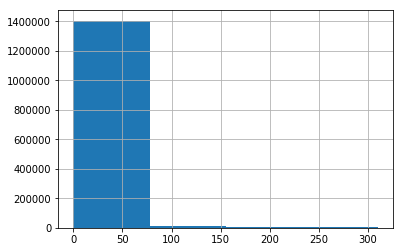

In [15]:
train_gd["mjd_delta"].to_pandas().hist(bins=4)

We can see that most deltas are < 90, so we should be able to threshold at 90 to determine gaps. 

Timeseries sequences can be numbered by marking a boolean `1` when a boundary condition occurs:
- The first time delta in the sequence will be zero, since it has no prior time to difference
- Any time delta gaps > 90 will signal a new timeseries sequence

Since the sequences have been ordered by id and time, they can be numbered in a monotonically increasing order using `cumsum()` 

In [30]:
boundary_thres = 90

train_gd['is_boundary'] = (train_gd['mjd_delta']>boundary_thres)|(train_gd['mjd_delta']==0)
train_gd['is_boundary'] = train_gd['is_boundary'].astype('int32')
train_gd = train_gd.sort_values(['object_id','mjd'])


train_gd['seq_id'] = train_gd['is_boundary'].cumsum()

Comparing to the [original light curve](#lightcurve), we can visually verfiy the curve is segmented correctly.

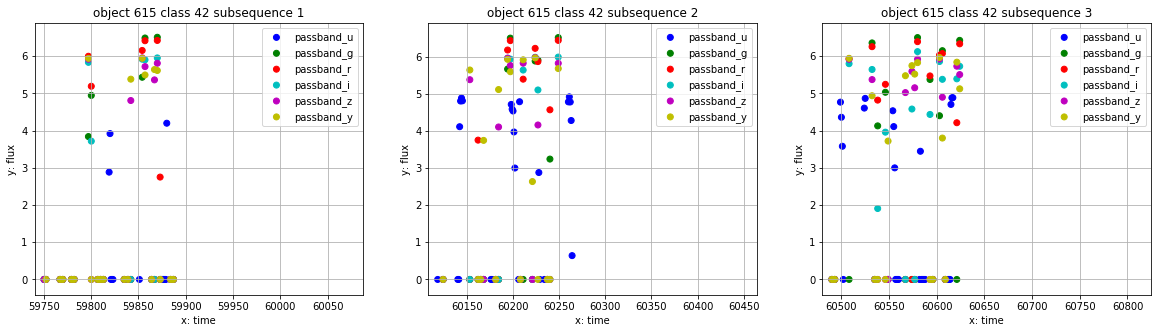

In [32]:
oid = 615
sample = train_gd[train_gd['object_id']==oid].to_pandas()
plt.figure(figsize=(20,5))
plt.subplot(131)
for i in range(1,4):
    plt.subplot(1,3,i)
    mask = sample.seq_id==i
    scatter(sample.loc[mask,'mjd'].values,
                sample.loc[mask,'flux'].values,
                values=sample.loc[mask,'passband'].values,
                xlim=(sample.loc[mask,'mjd'].min()-10,sample.loc[mask,'mjd'].max()+200),
                xlabel='time',ylabel='flux',title='object %d class 42 subsequence %d'%(oid,i))

### Reset the values of `flux_delta` and `mjd_delta` at the boundary of subsequence

In [33]:
train_gd['flux_delta'] = train_gd['flux_delta']*(1-train_gd['is_boundary'])
train_gd['mjd_delta'] = train_gd['mjd_delta']*(1-train_gd['is_boundary'])
train_gd.drop_column('is_boundary')

### Lastly, we scale `mjd_delta`

Text(0.5, 1.0, 'After scaling')

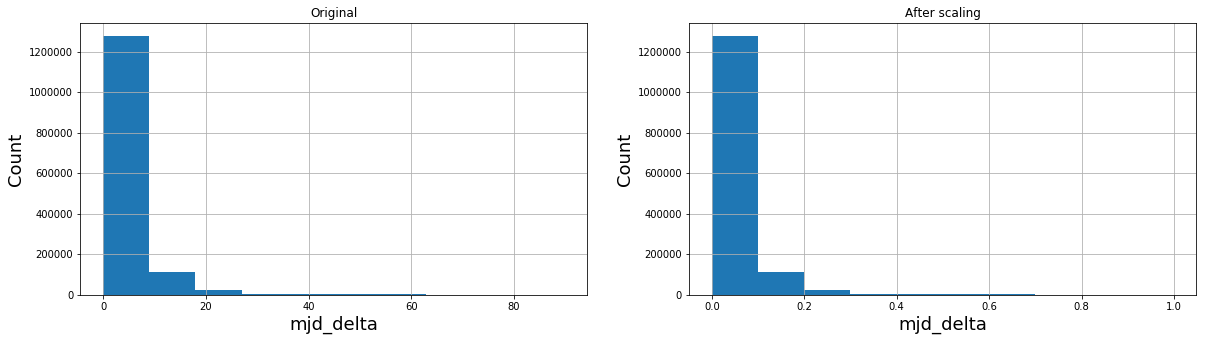

In [34]:
fig, axs = plt.subplots(1,2, figsize=(20, 5))
ax = train_gd.mjd_delta.to_pandas().hist(ax=axs[0])
ax.set_xlabel('mjd_delta', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('Original')

train_gd['mjd_delta'] /= boundary_thres # scale mjd_delta

ax = train_gd.mjd_delta.to_pandas().hist(ax=axs[1])
ax.set_xlabel('mjd_delta', fontsize=18)
ax.set_ylabel('Count', fontsize=18)
ax.set_title('After scaling')

### Remove unused columns

In [35]:
for col in ['mjd','flux','flux_err','detected']:
    train_gd.drop_column(col)

In [36]:
train_gd.head().to_pandas()

,object_id,passband,flux_delta,mjd_delta,seq_id
0,615,2,0.0,0.000000,1
1,615,1,0.0,0.000087,1
2,615,3,0.0,0.000087,1
3,615,4,0.0,0.000043,1
4,615,2,0.0,0.021832,1


### Conclusion

In this notebook we process the light curve data in order to train a RNN. 
- `object_id` and `seq_id` can be used to sample sequences from the dataframe.
- `mjd_delta` and `flux_delta` enable RNN to learn the temporal pattern of light curves.
- `passband` is an original feature and will be embedded.